In [1]:
import os

import pyopencl as cl
import numpy as np

import PIL.Image as im

from matplotlib import pyplot as plt

In [2]:
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

# Setting device and creating queue

In [3]:
current_platform = cl.get_platforms()[0] # selecting gpu (should use the first valid platform)
device = current_platform.get_devices()[0]
context = cl.Context([device])

print("Using device:", device.name)

queue = cl.CommandQueue(context)

Using device: gfx1031


# Creating buffers and setting quantities

In [4]:
RESOLUTION = 2**10
ITER_LIMIT = np.uint16(300)
INITIAL_Z = 0

X_LIM = (-2, 1)
Y_LIM = (-1.5, 1.5)

In [ ]:
x_array = np.linspace(*X_LIM, RESOLUTION, dtype=np.float32)
y_array = np.linspace(*Y_LIM, RESOLUTION, dtype=np.float32)

x_mesh, y_mesh = np.meshgrid(x_array, y_array)

image_array = np.zeros((RESOLUTION, RESOLUTION))

x_mesh = x_mesh.flatten().astype(np.float32)
y_mesh = y_mesh.flatten().astype(np.float32)

In [6]:
mf = cl.mem_flags

x_buf = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x_mesh)
y_buf = cl.Buffer(context, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_mesh)

matrix_output = np.empty(x_mesh.shape, dtype=np.uint16)
matrix_output_buf = cl.Buffer(context, mf.WRITE_ONLY, matrix_output.nbytes)

test_output = np.empty_like(x_mesh)
test_output_buf = cl.Buffer(context, mf.WRITE_ONLY, test_output.nbytes)

# Writing the kernel, compiling and executing

In [ ]:
kernel_code = """
__kernel void mandelbrot_iter (__global const float *c_real, __global const float *c_imag, __global ushort *output, const ushort max_iter)
{
    ulong idx = get_global_id(0);
    float z_real, n_real = 0.0;
    float z_imag = 0.0;

    output[idx] = 0;
    
    for (int cur_iter=0; cur_iter < max_iter; cur_iter++)
    {
        n_real = z_real * z_real - z_imag * z_imag + c_real[idx];
        z_imag = 2 * z_real * z_imag + c_imag[idx];
        z_real = n_real;

        if (z_real * z_real + z_imag * z_imag > 4.0f)
        {
            output[idx] = cur_iter;
            break;
        }
    }

    if (output[idx] == 0)
        output[idx] = max_iter;
}
"""

program = cl.Program(context, kernel_code).build()

/home/elvis/miniforge3/lib/python3.12/site-packages/pyopencl/cache.py:496: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'gfx1031' on 'AMD Accelerated Parallel Processing' at 0x5f8f9cddbc70> succeeded, but said:

1 warning generated.

  _create_built_program_from_source_cached(


: 

In [ ]:

program.mandelbrot_iter(queue, matrix_output.shape, None, x_buf, y_buf, matrix_output_buf, ITER_LIMIT).wait()

In [ ]:
cl.enqueue_copy(queue, matrix_output, matrix_output_buf).wait()

In [ ]:
matrix_image = im.fromarray(matrix_output.astype(np.uint8).reshape(RESOLUTION, RESOLUTION))
matrix_image.save("test_full.png")


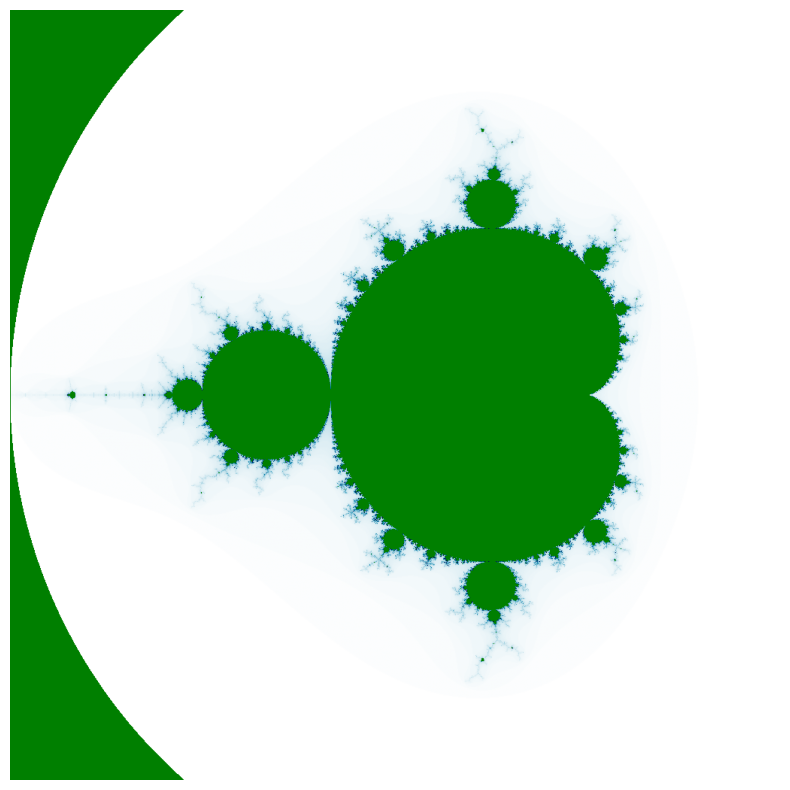

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(13, 10))



ax.imshow(matrix_output.reshape((RESOLUTION, RESOLUTION)),
             extent=(*X_LIM, *Y_LIM), cmap="ocean_r")

ax.set_aspect("equal")

ax.set_axis_off()


#fig.savefig("test.png", bbox_inches="tight", pad_inches=0)
